In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
cd drive/MyDrive/hope/english/

/content/drive/MyDrive/hope/english


In [3]:
ls

 Amrita_CEN_NLP_english.tsv   hope_english.mat
 data/                        hope_english_train_data.mat
 data_fst/                    hope_english_train_label.mat
 dev.csv                      hope_flair.ipynb
 english_hope_dev.csv         loss.tsv
 english_hope_test.csv        Sentiment_Analysis.ipynb
 english_hope_train.csv       spam.csv
 hope_deeplearning.ipynb      test.csv
'hope_english (1).ipynb'      train.csv
 hope_english_BERT.ipynb      training.log
 hope_english_dev_data.mat    Untitled0.ipynb
 hope_english_dev_label.mat   weights.txt
 hope_english.ipynb


In [4]:
import pandas as pd
import re
import numpy as np
import itertools
import collections
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import string
from wordcloud import WordCloud

import nltk
nltk.download('treebank')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 

import gensim
from gensim.models import KeyedVectors, Word2Vec, FastText

import tensorflow as tf

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [5]:
train_df = pd.read_csv("english_hope_train.csv", header=None, sep='\t')
train_df.head()

,0,1,2
0,these tiktoks radiate gay chaotic energy and i...,Non_hope_speech,NaN
1,@Champions Again He got killed for using false...,Non_hope_speech,NaN
2,It's not that all lives don't matter,Non_hope_speech,NaN
3,Is it really that difficult to understand? Bla...,Non_hope_speech,NaN
4,Whenever we say black isn't that racists? Why...,Non_hope_speech,NaN


In [6]:
valid_df = pd.read_csv("english_hope_dev.csv", header=None, sep='\t')
valid_df.head()

,0,1,2
0,Thats it.... like....I dont like that statue,Non_hope_speech,NaN
1,@Generation X Counting money that she been giv...,Non_hope_speech,NaN
2,@Paola Hernandez i never said to be intolerant...,Non_hope_speech,NaN
3,@Firstlast300 Wow An opinion is that I don't l...,Non_hope_speech,NaN
4,WOW!!!!!!!That was so so inspiring and incredi...,Hope_speech,NaN


In [7]:
test_df = pd.read_csv("english_hope_test.csv")
test_df.head()

,text,label
0,What do you mean by the word sniped?,Non_hope_speech
1,I love this video!! I’m bisexual and it’s just...,Hope_speech
2,ya the irony but then i don't want to come off...,Non_hope_speech
3,A PERSON'S CHARACTER MATTERS. PERIOD!!,Non_hope_speech
4,@Blaster of Gasters,Non_hope_speech


In [8]:
# Preprocessing - removing unwanted characters, tokenization, stop-word removal
def preprocess_data(tweet):
    user_name = '@[A-Za-z0-9]+' # Pattern for matching the user names in the tweet
    has_tag = '#[A-Za-z0-9]+' # Pattern for matching the hasgtags in the tweer
    url = 'https?:\/\/[A-Za-z0-9\.\/\-]+' # Pattern for matching the URLs in the tweet
    
    x = tweet.lower()  # Lower casing all the characters
    #x = re.sub(user_name, '@USER', x)  # Replace the username with @USER word -> Optional
    x = re.sub(user_name, '', x) # Replace the username with an empty characrer
    #x = re.sub(has_tag,'HASH',x) # Replace the hashtags with HASH word -> Optional
    x = re.sub(has_tag,'',x) # Replace the hashtags with an empty characrer
    #x = re.sub(url, 'URL', x) # Replace the URLs with URL word -> Optional
    x = re.sub(url, '', x) # Replace the URLs with an empty characrer
    x = re.sub("[^@a-zA-Z0-9]", " ",x) # Replace all the characters except alphabets and digits from the tweet
    x = re.sub("rt\s+",'',x) # Replace the retweet character "rt" from the tweet
    
    tokens = word_tokenize(x) # Tokenization; splitting the text into tokens
                          
    stop_words = list(set(stopwords.words("english")))
    negation_words = ["don't", "needn't", "won't", "wasn't", "didn't", "hadn't", "weren't", "not", "no", "hasn't", "nor", "shan't", "shouldn't", "isn't", "mustn't", "couldn't", "aren't", "haven't", "wouldn't", "doesn't", "mightn't"]
    stops = [w for w in stop_words if not w in negation_words]           
    words = [w for w in tokens if not w in stops] 

    return(" ".join(words)) # Combine the tokenized words to form a sentence

In [9]:
train_df[0] = train_df[0].apply(lambda x: preprocess_data(x)) # Apply the clean_data() to all the entries in the dataframe
valid_df[0] = valid_df[0].apply(lambda x: preprocess_data(x)) # Apply the clean_data() to all the entries in the dataframe
test_df['text'] = test_df['text'].apply(lambda x: preprocess_data(x)) # Apply the clean_data() to all the entries in the dataframe

In [10]:
print(train_df.head())
print()
print(valid_df.head())
print()
print(test_df.head())

                                                   0                1   2
0            tiktoks radiate gay chaotic energy love  Non_hope_speech NaN
1                       got killed using false money  Non_hope_speech NaN
2                                   not lives matter  Non_hope_speech NaN
3  really difficult understand black lives matter...  Non_hope_speech NaN
4           whenever say black racists say americans  Non_hope_speech NaN

                                                   0                1   2
0                        thats like dont like statue  Non_hope_speech NaN
1  x counting money given promoting hysterical gr...  Non_hope_speech NaN
2            hernandez never said intolerant hateful  Non_hope_speech NaN
3                             wow opinion like color  Non_hope_speech NaN
4          wow inspiring incredible speech saved day      Hope_speech NaN

                                                text            label
0                                   mean

In [11]:
train_text = train_df[0].tolist()
valid_text = valid_df[0].tolist()
test_text = test_df['text'].tolist()

train_label = train_df[1].tolist()
valid_label = valid_df[1].tolist()

In [12]:
class_names = list(set(train_label))
class_names

['Non_hope_speech', 'Hope_speech', 'not-English']

In [13]:
class_dist = Counter(train_label)
class_dist

Counter({'Hope_speech': 1962, 'Non_hope_speech': 20778, 'not-English': 22})

In [14]:
le = LabelEncoder()

train_label = le.fit_transform(train_label)
valid_label = le.fit_transform(valid_label)

In [18]:
le.inverse_transform([0,1,2])

array(['Hope_speech', 'Non_hope_speech', 'not-English'], dtype='<U15')

In [19]:
class_weight = {0:sum(class_dist.values())/class_dist[le.inverse_transform([0])[0]],
                1:sum(class_dist.values())/class_dist[le.inverse_transform([1])[0]],
                2:sum(class_dist.values())/class_dist[le.inverse_transform([2])[0]]}

class_weight

{0: 11.601427115188583, 1: 1.0954856097795747, 2: 1034.6363636363637}

In [20]:
training_labels = tf.keras.utils.to_categorical(train_label)
validation_labels = tf.keras.utils.to_categorical(valid_label)

In [21]:
words_in_train = [sent.split() for sent in train_text] # Splitting the tweet into tokens
words_in_train[0:5]

[['tiktoks', 'radiate', 'gay', 'chaotic', 'energy', 'love'],
 ['got', 'killed', 'using', 'false', 'money'],
 ['not', 'lives', 'matter'],
 ['really',
  'difficult',
  'understand',
  'black',
  'lives',
  'matter',
  'lives',
  'matter',
  'not',
  'mutually',
  'exclusive',
  'true',
  'general',
  'statements',
  'white',
  'lives',
  'matter',
  'asian',
  'lives',
  'matter',
  'black',
  'lives',
  'matter',
  'context',
  'simply',
  'name',
  'movement',
  'strangely',
  'high',
  'rate',
  'police',
  'violence',
  'black',
  'people',
  'statement',
  'referring',
  'behave',
  'like',
  'treat',
  'black',
  'people',
  'dont',
  'matter',
  'example'],
 ['whenever', 'say', 'black', 'racists', 'say', 'americans']]

In [22]:
words_in_valid = [sent.split() for sent in valid_text] # Splitting the tweet into tokens
words_in_valid[0:5]

[['thats', 'like', 'dont', 'like', 'statue'],
 ['x',
  'counting',
  'money',
  'given',
  'promoting',
  'hysterical',
  'green',
  'agenda'],
 ['hernandez', 'never', 'said', 'intolerant', 'hateful'],
 ['wow', 'opinion', 'like', 'color'],
 ['wow', 'inspiring', 'incredible', 'speech', 'saved', 'day']]

In [23]:
words_in_test = [sent.split() for sent in test_text] # Splitting the tweet into tokens
words_in_test[0:5]

[['mean', 'word', 'sniped'],
 ['love',
  'video',
  'bisexual',
  'really',
  'nice',
  'hear',
  'someone',
  'gone',
  'similar',
  'things',
  'like',
  'not',
  'alone',
  'story',
  'nothing',
  'like',
  'heagoes',
  'slowly',
  'heal'],
 ['ya', 'irony', 'want', 'come', 'bigot'],
 ['person', 'character', 'matters', 'period'],
 ['gasters']]

In [24]:
all_words_train = list(itertools.chain(*words_in_train)) # Making a flatlist of all the words in the corpus
all_words_train[0:10]

['tiktoks',
 'radiate',
 'gay',
 'chaotic',
 'energy',
 'love',
 'got',
 'killed',
 'using',
 'false']

In [25]:
all_words_valid = list(itertools.chain(*words_in_valid)) # Making a flatlist of all the words in the corpus
all_words_valid[0:10]

['thats',
 'like',
 'dont',
 'like',
 'statue',
 'x',
 'counting',
 'money',
 'given',
 'promoting']

In [26]:
all_words_test = list(itertools.chain(*words_in_test)) # Making a flatlist of all the words in the corpus
all_words_test[0:10]

['mean',
 'word',
 'sniped',
 'love',
 'video',
 'bisexual',
 'really',
 'nice',
 'hear',
 'someone']

In [27]:
all_words = all_words_train + all_words_valid + all_words_test
corpus = train_text + valid_text + test_text
vocab_size = len(set(all_words)) # number of words to keep.
embedding_dim = 100 # Dimension of the vector representation for each word 
max_length = 0
for i in range(len(corpus)):
  x = word_tokenize(corpus[i])
  if len(x) > max_length:
    max_length = len(x)

oov_tok = "<OOV>"  # Token to represent Out-of-Vocabulary words

In [33]:
max_length

104

In [28]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_text)
word_index = tokenizer.word_index

In [29]:
# Pad the sequences so that they are all the same length
training_sequences = tokenizer.texts_to_sequences(train_text)
training_padded = tf.keras.preprocessing.sequence.pad_sequences(training_sequences,maxlen=max_length, padding='post')

valid_sequences = tokenizer.texts_to_sequences(valid_text)
valid_padded = tf.keras.preprocessing.sequence.pad_sequences(valid_sequences,maxlen=max_length, padding='post')

train_padded = np.concatenate((training_padded, valid_padded), axis=0)

test_sequences = tokenizer.texts_to_sequences(test_text)
test_padded = tf.keras.preprocessing.sequence.pad_sequences(test_sequences,maxlen=max_length, padding='post')

In [31]:
METRICS = [
      #tf.keras.metrics.TruePositives(name='tp'),
      #tf.keras.metrics.FalsePositives(name='fp'),
      #tf.keras.metrics.TrueNegatives(name='tn'),
      #tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.Accuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]

In [32]:
filter_size = 128
kernel_size = 5
pool_size = 5

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(filter_size, kernel_size, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size, padding='same'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    #tf.keras.layers.GlobalAveragePooling1D(), 
    tf.keras.layers.Dense(32, activation=tf.nn.relu),
    tf.keras.layers.Dense(3, activation=tf.nn.softmax)
])

model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    #metrics=[tf.keras.metrics.PrecisionAtRecall(recall=0.8)]
    metrics=METRICS
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 104, 100)          2056800   
                                                                 
 conv1d (Conv1D)             (None, 104, 128)          64128     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 21, 128)          0         
 )                                                               
                                                                 
 bidirectional (Bidirectiona  (None, 64)               41216     
 l)                                                              
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 3)                 9

In [35]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True) # Early stopping is a regularizatiion technique 
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=10, mode='max', restore_best_weights=True) # Early stopping is a regularizatiion technique 

num_epochs = 100
history = model.fit(
    training_padded, 
    training_labels, 
    epochs=num_epochs, 
    batch_size = 32,
    callbacks=[callback], # calling early stopping
    #validation_data=(valid_padded, validation_labels)
    validation_split=0.1,
    class_weight=class_weight  # provide class weights to deal with the class imbalance problem - This process is also called as cost-sensitive learning
)

Epoch 1/100
641/641 [==============================] - 50s 78ms/step - loss: 3.5479 - accuracy: 0.0000e+00 - precision: 0.0312 - recall: 4.8816e-05 - auc: 0.3215 - val_loss: 1.0842 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9552
Epoch 2/100
641/641 [==============================] - 50s 78ms/step - loss: 3.4421 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4985 - val_loss: 1.1452 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.2500
Epoch 3/100
184/641 [=======>......................] - ETA: 40s - loss: 2.9747 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.3745

KeyboardInterrupt: ignored

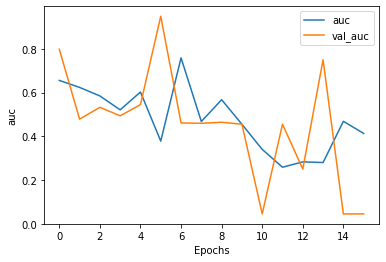

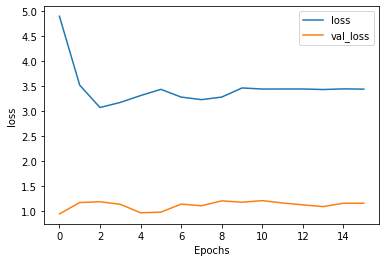

In [30]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "auc")
plot_graphs(history, "loss")

In [32]:
classes = model.predict(test_padded)
pred = []

for i in range(len(classes)):
  pred.append(le.inverse_transform([classes[i]])[0])

ValueError: ignored

In [ ]:
pred[0:7]

In [ ]:
pred_df = pd.DataFrame(pred, columns=['label'])
pred_df.head()

In [ ]:
result = pd.concat([test_df, pred_df], axis=1)
result.head()

In [ ]:
result.to_csv('Amrita_CEN_NLP_english.tsv', sep = '\t', index=False)